In [1]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Library imports
import torch
import matplotlib.pyplot as plt

In [2]:
# Import necessary utilities from my_small_prior
from scripts.my_small_prior import get_random_dataset, RandomPriorMLP

# Obtain synthetic dataset from the generator
X_train, y_train, X_test, y_test, mlp = get_random_dataset(return_mlp=True)

# Save dataset values
train_size = X_train.shape[1]
test_size = X_test.shape[1]
B = X_train.shape[0]

# Prints
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(mlp.layer_sizes)

torch.Size([4, 21, 19])
torch.Size([4, 21, 1])
torch.Size([4, 128, 19])
torch.Size([4, 128, 1])
[21, 20]


In [3]:
# Import necessary utilities from my_small_PFN
from scripts.my_small_PFN import ModelConfig, MyRegressorPFN, BucketOps

# Get global config
config = ModelConfig()

# Obtain target labels from real line discretization
target = BucketOps.real_to_bucket(config.n_buckets, y_test).squeeze(-1) # (B, test_size)

# Flatten target to obtain labels (for nn.CrossEntropyLoss)
labels = target.reshape(-1) # (B * test_size)

# Prints
print(target.shape, target.dtype)
print(labels.shape, labels.dtype)

torch.Size([4, 128]) torch.int64
torch.Size([512]) torch.int64


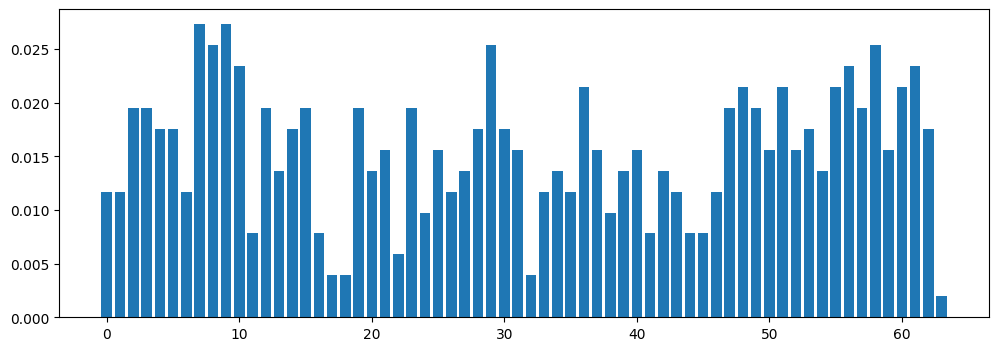

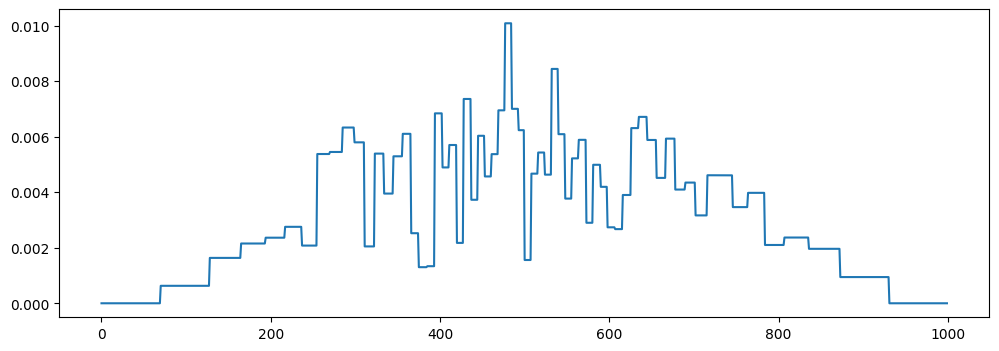

0.00633930042386055 1.0256307125091553 1.012734293937683
(0.00473419763147831, 1.0225322246551514, 1.011203408241272)


In [4]:
# Study the labels distribution

# Count occurrences of each bucket
counts = torch.bincount(labels, minlength=config.n_buckets).cpu()
probs = counts / (B * test_size)

# Plot histogram
plt.figure(figsize=(12, 4))
plt.bar(range(config.n_buckets), probs.numpy())
plt.show()

# Plot distribution
plt.figure(figsize=(12, 4))
plt.plot(BucketOps.probs_to_distribution_plot(probs, torch.arange(0,1000)/200-2.5))
plt.show()

# Print original and approximated values
print(y_test.flatten().mean().item(),y_test.flatten().var().item(),y_test.flatten().std().item())
print(BucketOps.probs_to_mean_var_std(probs))

torch.Size([4, 128, 64])
True


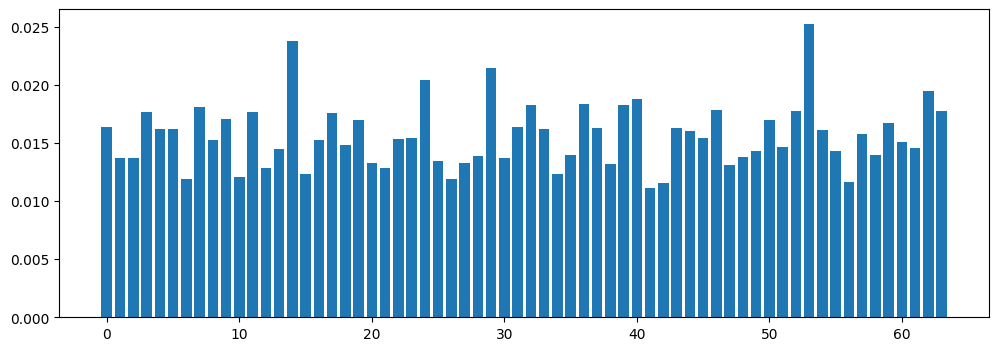

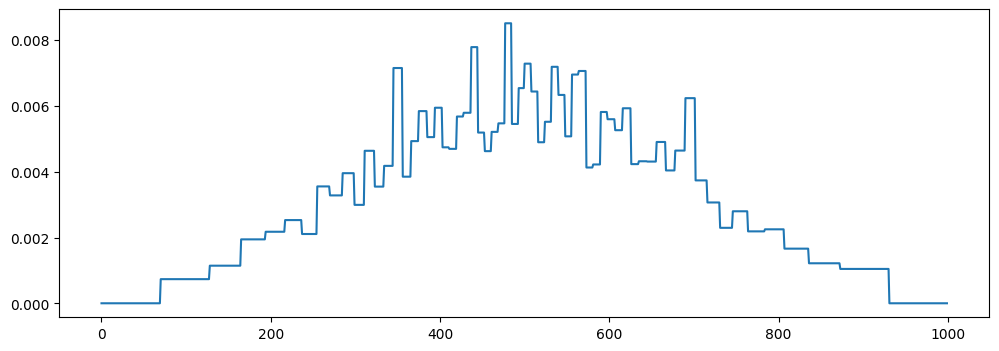

(0.015245795249938965, 1.0206193923950195, 1.0102571249008179)


In [5]:
# Create a default config
config = ModelConfig()

# Create a model using the default config
model = MyRegressorPFN(config)

# Set the model to train mode
model.train()

# Call fit and predict to do an entire forward pass
model_out = model.fit(X_train, y_train).predict(X_test, output='logits')
print(model_out.shape)
print(model_out.requires_grad)

# Obtain probabilities by applying softmax to logits
probs = torch.softmax(model_out[0,0], dim=0).cpu().detach()

# Study output to make sure it matches target distribution ~N(0,1), it does!

# Plot histogram
plt.figure(figsize=(12, 4))
plt.bar(range(config.n_buckets), probs)
plt.show()

# Plot distribution
plt.figure(figsize=(12, 4))
plt.plot(BucketOps.probs_to_distribution_plot(probs, torch.arange(0,1000)/200-2.5))
plt.show()

# Print approximated values
print(BucketOps.probs_to_mean_var_std(probs))

In [6]:
# Import necessary utilities from my_small_training
from scripts.my_small_training import training_loop, TrainConfig

# Make a custom config for a simple test run
config = TrainConfig()
config.effective_batch_size = 4
config.finish_at_epoch = 10

# Prints
print(config.model_config)
print(config.prior_config)

# Do a small training run
training_loop(config)

ModelConfig(embedded_dimension=64, n_layers=12, n_heads=2, hidden_dimension_ff=256, hidden_dimension_enc=256, hidden_dimension_dec=256, feature_group_size=3, n_thinking_rows=16, n_buckets=64, temperature=1.0, device='cuda')
PriorConfig(prob_next_layer=0.5, link_dropout_rate=0.55, noise_multiplier=0.1, max_nodes_per_layer=24, non_linears=[<class 'torch.nn.modules.activation.ReLU'>, <class 'torch.nn.modules.activation.LeakyReLU'>, <class 'torch.nn.modules.activation.Tanh'>, <class 'torch.nn.modules.activation.Sigmoid'>], max_train_rows=256, n_test_rows=128, max_features=24, batch_size=4, device='cuda')
Epoch 0001 reached | LR: 0.0002 | Accumulated loss: 4.1807 | Time elapsed 0.46s
Epoch 0002 reached | LR: 0.0004 | Accumulated loss: 4.1821 | Time elapsed 0.15s
Epoch 0003 reached | LR: 0.0006 | Accumulated loss: 4.1715 | Time elapsed 0.47s
Epoch 0004 reached | LR: 0.0008 | Accumulated loss: 4.1939 | Time elapsed 0.22s
Epoch 0005 reached | LR: 0.0010 | Accumulated loss: 4.1591 | Time elapse